# Body Posture Classification using KNN and MediaPipe

This notebook demonstrates how to:

1. Extract pose landmarks from video frames using MediaPipe
2. Train a KNN classifier to classify body postures (sitting, standing, laying)
3. Evaluate the model performance
4. Make predictions on new frames


In [21]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import os
from pathlib import Path
import seaborn as sns
from typing import List, Tuple, Dict
import warnings

warnings.filterwarnings("ignore")

print("Libraries imported successfully.")

Libraries imported successfully.


## 1. Pose Landmark Extraction

In [22]:
class PoseLandmarkExtractor:
    """Extract pose landmarks from frames using MediaPipe"""

    def __init__(self):
        """Initialize MediaPipe pose detection"""
        self.mp_pose = mp.solutions.pose
        self.pose = self.mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5,
        )

        self.num_landmarks = 33
        self.features_per_landmark = 3  # x, y, z
        self.total_features = (
            self.num_landmarks * self.features_per_landmark
        )  # 99 features

    def extract_landmarks_from_frame(self, frame: np.ndarray) -> np.ndarray:
        """
        Extract pose landmarks from a single frame

        Args:
            frame: Input frame (BGR format)

        Returns:
            Array of 99 features (33 landmarks × 3 coordinates)
        """
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        results = self.pose.process(rgb_frame)

        features = np.zeros(self.total_features)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark

            for i, landmark in enumerate(landmarks):
                features[i * 3] = landmark.x  # x coordinate
                features[i * 3 + 1] = landmark.y  # y coordinate
                features[i * 3 + 2] = landmark.z  # z coordinate

        return features

    def extract_landmarks_from_frames(self, frames: List[np.ndarray]) -> np.ndarray:
        """
        Extract landmarks from multiple frames

        Args:
            frames: List of frames

        Returns:
            Array of shape (num_frames, 99) containing landmark features
        """
        features_list = []

        for i, frame in enumerate(frames):
            if i % 10 == 0:  # Progress update every 10 frames
                print(f"   Extracting landmarks from frame {i+1}/{len(frames)}...")
            features = self.extract_landmarks_from_frame(frame)
            features_list.append(features)

        return np.array(features_list)

    def close(self):
        """Close the pose detector"""
        if self.pose:
            self.pose.close()

print("PoseLandmarkExtractor class created.")

PoseLandmarkExtractor class created.


## 2. Frame Extraction from Videos

In [23]:
def extract_frames_from_video(
    video_path: str, sample_rate: int = 60
) -> List[np.ndarray]:
    """
    Extract frames from video file

    Args:
        video_path: Path to video file
        sample_rate: Extract every nth frame

    Returns:
        List of frames
    """
    frames_array = []
    video_capture = cv2.VideoCapture(video_path)

    if not video_capture.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return frames_array

    fps = video_capture.get(cv2.CAP_PROP_FPS)
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps if fps > 0 else 0

    if fps <= 0:
        print(f"Warning: Unable to obtain framerate for video: {video_path}")
        video_capture.release()
        return frames_array

    print(
        f"Processing: {os.path.basename(video_path)} (FPS: {fps:.1f}, Duration: {duration:.1f}s)"
    )

    frame_index = 0
    while True:
        success, frame = video_capture.read()
        if not success:
            break

        if frame_index % sample_rate == 0:
            frames_array.append(frame)

        frame_index += 1

    video_capture.release()
    print(f"✅ Extracted {len(frames_array)} frames")
    return frames_array

print("Frame extraction function created.")

Frame extraction function created.


## 3. Dataset Preparation

Let's prepare our dataset by extracting landmarks from videos in each posture class.


In [51]:
def prepare_dataset(
    data_dir: str, max_videos_per_class: int = 20
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Prepare dataset from video files in Data directory

    Args:
        data_dir: Path to Data directory
        max_videos_per_class: Maximum number of videos to process per class

    Returns:
        Tuple of (features, labels)
    """
    features_list = []
    labels_list = []

    extractor = PoseLandmarkExtractor()

    try:
        class_mapping = {"Sitting": 0, "Standing": 1, "laying": 2}

        for posture, class_idx in class_mapping.items():
            print(f"\nProcessing {posture} posture")

            posture_dir = Path(data_dir) / posture
            if not posture_dir.exists():
                print(f"Directory {posture} not found, skipping...")
                continue

            video_files = list(posture_dir.glob("*.mp4"))
            print(f"Found {len(video_files)} video files")

            for i, video_path in enumerate(video_files[:max_videos_per_class]):
                print(
                    f"Processing video {i+1}/{min(len(video_files), max_videos_per_class)}: {video_path.name}"
                )

                # Extract frames
                frames = extract_frames_from_video(str(video_path), sample_rate=60)

                if frames:
                    # Extract landmarks from frames
                    frame_features = extractor.extract_landmarks_from_frames(frames)
                    
                    # Filter out frames with too many missing landmarks (zero values)
                    valid_frames = []
                    valid_labels = []
                    for frame_idx, frame_feature in enumerate(frame_features):
                        # Count number of zero coordinates (missing landmarks)
                        zero_coords = np.count_nonzero(frame_feature == 0)
                        # Keep frame if less than 20% of coordinates are missing
                        if zero_coords < (len(frame_feature) * 0.2):
                            valid_frames.append(frame_feature)
                            valid_labels.append(class_idx)
                    
                    # Add the valid frames and labels to the main lists
                    features_list.extend(valid_frames)
                    labels_list.extend(valid_labels)
                    
                    print(f"Extracted {len(frame_features)} frames, kept {len(valid_frames)} valid frames")
                else:
                    print(f"No frames extracted from {video_path.name}")

    finally:
        extractor.close()

    # Convert to numpy arrays
    features = np.array(features_list)
    labels = np.array(labels_list)

    print(f"\nDataset prepared:")
    print(f"Total samples: {len(features)}")
    
    # Only try to access shape[1] if we have samples
    if len(features) > 0:
        print(f"Features per sample: {features.shape[1]}")
    else:
        print("No valid samples found!")

    class_names = ["sitting", "standing", "laying"]
    if len(labels) > 0:
        unique, counts = np.unique(labels, return_counts=True)
        for class_idx, count in zip(unique, counts):
            print(f"   {class_names[class_idx]}: {count} samples")
    else:
        print("No labels found!")

    return features, labels

features, labels = prepare_dataset("Data", max_videos_per_class=50)



Processing Sitting posture
Found 985 video files
Processing video 1/50: Readbook_p12_r00_v05_c05.mp4
Processing: Readbook_p12_r00_v05_c05.mp4 (FPS: 20.0, Duration: 21.8s)
✅ Extracted 8 frames
   Extracting landmarks from frame 1/8...
Extracted 8 frames, kept 6 valid frames
Processing video 2/50: Readbook_p19_r01_v04_c05.mp4
Processing: Readbook_p19_r01_v04_c05.mp4 (FPS: 20.0, Duration: 173.7s)
✅ Extracted 58 frames
   Extracting landmarks from frame 1/58...
   Extracting landmarks from frame 11/58...
   Extracting landmarks from frame 21/58...
   Extracting landmarks from frame 31/58...
   Extracting landmarks from frame 41/58...
   Extracting landmarks from frame 51/58...
Extracted 58 frames, kept 9 valid frames
Processing video 3/50: Drink.Fromcan_p03_r02_v07_c04.mp4
Processing: Drink.Fromcan_p03_r02_v07_c04.mp4 (FPS: 20.0, Duration: 3.7s)
✅ Extracted 2 frames
   Extracting landmarks from frame 1/2...
Extracted 2 frames, kept 2 valid frames
Processing video 4/50: Readbook_p06_r03_v0

## 4. Data Visualization

Let's visualize the class distribution and feature statistics.


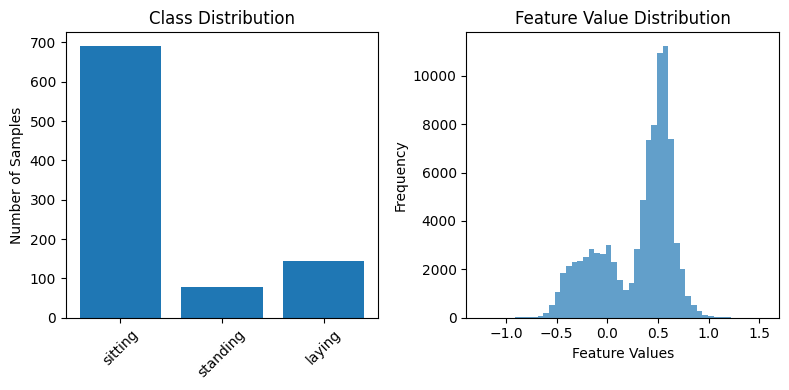

In [52]:
# Visualize class distribution
plt.figure(figsize=(12, 4))

# Class distribution
plt.subplot(1, 3, 1)
class_names = ["sitting", "standing", "laying"]
unique, counts = np.unique(labels, return_counts=True)
plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

# Feature statistics
plt.subplot(1, 3, 2)
plt.hist(features.flatten(), bins=50, alpha=0.7)
plt.title("Feature Value Distribution")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 5. Resampling

In [53]:
from sklearn.utils import resample

data = np.hstack((features, labels.reshape(-1, 1)))

sitting = data[data[:, -1] == 0]
standing = data[data[:, -1] == 1]
laying = data[data[:, -1] == 2]

max_samples = max(len(sitting), len(standing), len(laying))
print(f"Max samples: {max_samples}")

sitting_upsampled = resample(
    sitting,
    replace=True,  
    n_samples=max_samples,
    random_state=42
)

standing_upsampled = resample(
    standing,
    replace=True,
    n_samples=max_samples,
    random_state=42
)

laying_upsampled = resample(
    laying,
    replace=True,
    n_samples=max_samples,
    random_state=42
)

balanced_arrays = [
    arr for arr in [sitting_upsampled, standing_upsampled, laying_upsampled]
    if arr is not None and len(arr) > 0
]
balanced_data = np.vstack(balanced_arrays)
np.random.shuffle(balanced_data)

features = balanced_data[:, :-1]
labels = balanced_data[:, -1].astype(int)

unique, counts = np.unique(labels, return_counts=True)
for class_idx, count in zip(unique, counts):
    print(f"   {['sitting', 'standing', 'laying'][class_idx]}: {count} samples")

Max samples: 691
   sitting: 691 samples
   standing: 691 samples
   laying: 691 samples


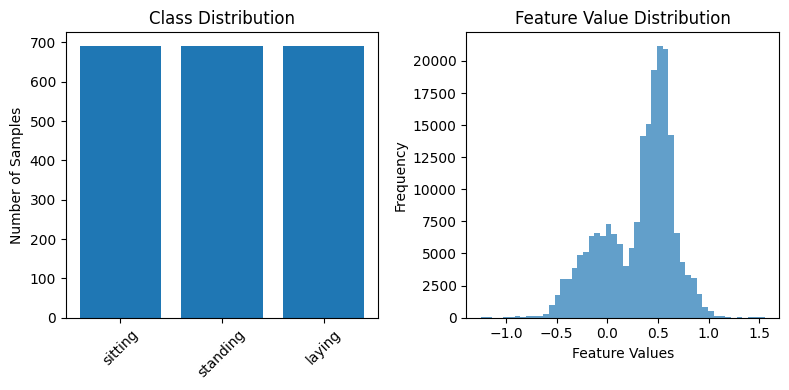

In [54]:
# Visualize class distribution
plt.figure(figsize=(12, 4))

# Class distribution
plt.subplot(1, 3, 1)
class_names = ["sitting", "standing", "laying"]
unique, counts = np.unique(labels, return_counts=True)
plt.bar(class_names, counts)
plt.title("Class Distribution")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

# Feature statistics
plt.subplot(1, 3, 2)
plt.hist(features.flatten(), bins=50, alpha=0.7)
plt.title("Feature Value Distribution")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## 6. KNN Classifier Training

Now let's train our KNN classifier with hyperparameter tuning.


In [55]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Training samples: 1658
Test samples: 415


In [56]:
# Hyperparameter tuning for KNN
print("🔍 Performing hyperparameter tuning...")

# Define parameter grid
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

# Grid search with cross-validation
knn = KNeighborsClassifier()
grid_search = GridSearchCV(
    knn, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\n🎯 Best parameters: {grid_search.best_params_}")
print(f"📊 Best cross-validation score: {grid_search.best_score_:.3f}")

# Get best model
best_knn = grid_search.best_estimator_

print("✅ Hyperparameter tuning completed!")

🔍 Performing hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

🎯 Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
📊 Best cross-validation score: 0.993
✅ Hyperparameter tuning completed!


In [57]:
# Train final model and make predictions
print("🎯 Training final KNN model...")

# Train on full training set
best_knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = best_knn.predict(X_test_scaled)
y_pred_proba = best_knn.predict_proba(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ Training completed!")
print(f"📊 Test accuracy: {accuracy:.3f}")

🎯 Training final KNN model...
✅ Training completed!
📊 Test accuracy: 0.995


## 7. Model Evaluation

Let's evaluate our model performance with detailed metrics.


📊 Model Evaluation:

📋 Classification Report:
              precision    recall  f1-score   support

     sitting       1.00      1.00      1.00       138
    standing       0.99      1.00      0.99       138
      laying       1.00      0.99      0.99       139

    accuracy                           1.00       415
   macro avg       1.00      1.00      1.00       415
weighted avg       1.00      1.00      1.00       415


🎯 Confusion Matrix:


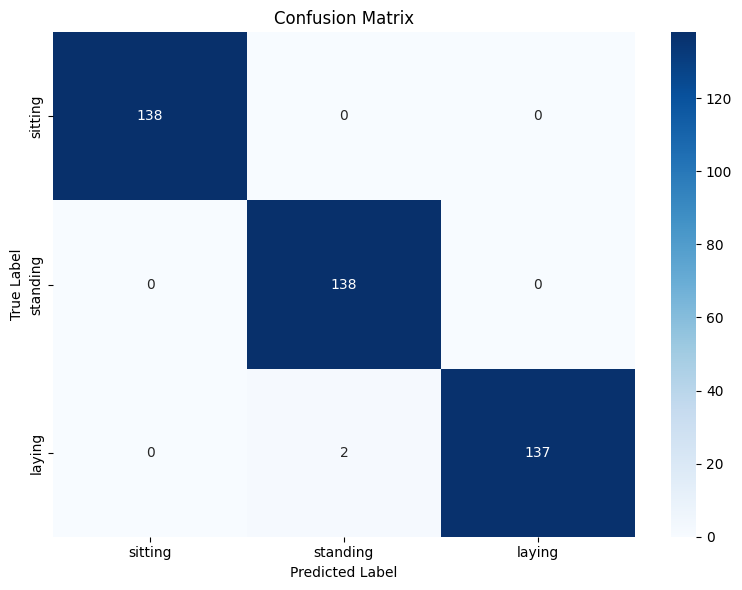


🔄 Cross-Validation Score:
   Mean CV accuracy: 0.993 (+/- 0.009)
✅ Model evaluation completed!


In [58]:
# Model evaluation
print("📊 Model Evaluation:")
print("=" * 50)

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion matrix
print("\n🎯 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Cross-validation score
print("\n🔄 Cross-Validation Score:")
cv_scores = cross_val_score(best_knn, X_train_scaled, y_train, cv=5)
print(f"   Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

print("✅ Model evaluation completed!")

## 8. Feature Importance Analysis

Let's analyze which pose landmarks are most important for classification.


🔍 Analyzing feature importance...


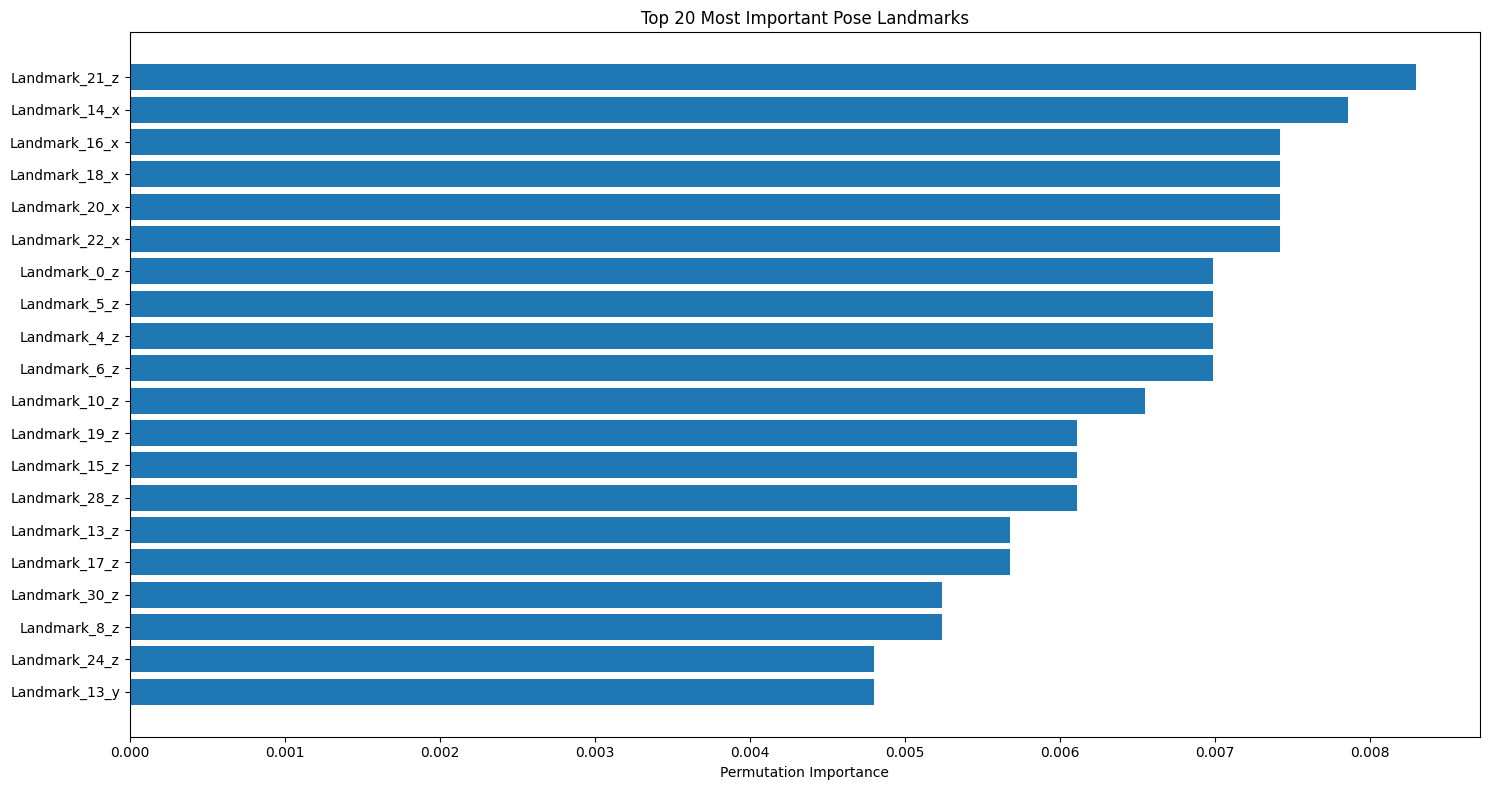

✅ Feature importance analysis completed!


In [31]:
# Feature importance analysis using permutation importance
from sklearn.inspection import permutation_importance

print("🔍 Analyzing feature importance...")

# Calculate permutation importance
result = permutation_importance(
    best_knn, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Get feature names (landmark coordinates)
landmark_names = []
for i in range(33):  # 33 landmarks
    landmark_names.extend([f"Landmark_{i}_x", f"Landmark_{i}_y", f"Landmark_{i}_z"])

# Plot feature importance
plt.figure(figsize=(15, 8))

# Top 20 most important features
top_indices = np.argsort(result.importances_mean)[-20:]
top_features = [landmark_names[i] for i in top_indices]
top_importances = result.importances_mean[top_indices]

plt.barh(range(len(top_features)), top_importances)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel("Permutation Importance")
plt.title("Top 20 Most Important Pose Landmarks")
plt.tight_layout()
plt.show()

print("✅ Feature importance analysis completed!")

## 9. Model Saving and Loading

Let's save our trained model for future use.


In [32]:
import joblib

# Save model and scaler
model_data = {
    "knn": best_knn,
    "scaler": scaler,
    "class_names": class_names,
    "feature_names": landmark_names,
}

joblib.dump(model_data, "body_posture_classifier.pkl")
print("✅ Model saved to 'body_posture_classifier.pkl'")

# Test loading the model
loaded_model_data = joblib.load("body_posture_classifier.pkl")
loaded_knn = loaded_model_data["knn"]
loaded_scaler = loaded_model_data["scaler"]
loaded_class_names = loaded_model_data["class_names"]

print("✅ Model loaded successfully!")
print(f"   Classes: {loaded_class_names}")

✅ Model saved to 'body_posture_classifier.pkl'
✅ Model loaded successfully!
   Classes: ['sitting', 'standing', 'laying']


## 10. Real-time Prediction Function

Create a function to predict posture from a single frame.


In [33]:
def predict_posture_from_frame(
    frame: np.ndarray, model_data: dict
) -> Tuple[str, float]:
    """
    Predict posture for a single frame

    Args:
        frame: Input frame (BGR format)
        model_data: Loaded model data

    Returns:
        Tuple of (predicted_class, confidence)
    """
    # Extract landmarks
    extractor = PoseLandmarkExtractor()
    try:
        features = extractor.extract_landmarks_from_frame(frame)
        features_scaled = model_data["scaler"].transform(features.reshape(1, -1))

        # Predict
        prediction = model_data["knn"].predict(features_scaled)[0]
        confidence = model_data["knn"].predict_proba(features_scaled)[0].max()

        return model_data["class_names"][prediction], confidence
    finally:
        extractor.close()


# Test prediction on a sample frame
if len(X_test) > 0:
    # Use the first test sample as example
    sample_features = X_test[0]
    sample_features_scaled = scaler.transform(sample_features.reshape(1, -1))

    prediction = best_knn.predict(sample_features_scaled)[0]
    confidence = best_knn.predict_proba(sample_features_scaled)[0].max()

    print(f"\n🧪 Sample Prediction Test:")
    print(f"   True class: {class_names[y_test[0]]}")
    print(f"   Predicted class: {class_names[prediction]}")
    print(f"   Confidence: {confidence:.3f}")

print("✅ Prediction function created!")


🧪 Sample Prediction Test:
   True class: laying
   Predicted class: laying
   Confidence: 0.600
✅ Prediction function created!


## 11. Summary and Next Steps

Let's summarize our results and suggest improvements.


In [34]:
print("🎉 Body Posture Classification Summary")
print("=" * 50)
print(f"📊 Dataset size: {len(features)} samples")
print(f"🔢 Features per sample: {features.shape[1]} (33 landmarks × 3 coordinates)")
print(f"🎯 Best KNN parameters: {grid_search.best_params_}")
print(f"📈 Test accuracy: {accuracy:.3f}")
print(
    f"🔄 Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})"
)
print(f"💾 Model saved: body_posture_classifier.pkl")

print("\n🚀 Next Steps:")
print("1. Collect more data for better class balance")
print("2. Try other algorithms (Random Forest, SVM, Neural Networks)")
print("3. Implement real-time video classification")
print("4. Add data augmentation techniques")
print("5. Fine-tune MediaPipe parameters")

print("\n✅ Classification pipeline completed successfully!")

🎉 Body Posture Classification Summary
📊 Dataset size: 1143 samples
🔢 Features per sample: 99 (33 landmarks × 3 coordinates)
🎯 Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
📈 Test accuracy: 0.686
🔄 Cross-validation accuracy: 0.677 (+/- 0.061)
💾 Model saved: body_posture_classifier.pkl

🚀 Next Steps:
1. Collect more data for better class balance
2. Try other algorithms (Random Forest, SVM, Neural Networks)
3. Implement real-time video classification
4. Add data augmentation techniques
5. Fine-tune MediaPipe parameters

✅ Classification pipeline completed successfully!
